# SMA Mini Project :
### Topic Modeling on App Reviews for Insights Using LDA

# Atharva Khanvilkar  
# D16AD - 33

In [1]:
!pip install google-play-scraper app-store-scraper pyLDAvis numpy==1.23.5 gensim==4.3.1 scipy==1.10.1 nltk

  Using cached gensim-4.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.4 kB)
Using cached gensim-4.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.6 MB)


In [2]:
# Imports

import pandas as pd
import numpy as np
import json
from google_play_scraper import reviews, Sort
from app_store_scraper import AppStore

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

import spacy
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Scraping

In [3]:
total_reviews=1000

### Google Play Store reviews

In [4]:
def scrape_google_reviews(app_id, total_reviews=100):
    all_reviews = []
    count = 100  # batch size
    sort_order = Sort.NEWEST  # sort by new
    continuation_token = None

    while len(all_reviews) < total_reviews:
        try:
            rvws, continuation_token = reviews(
                app_id,
                lang='en',
                country='us',
                sort=sort_order,
                count=count,
                continuation_token=continuation_token
            )
            all_reviews.extend(rvws)
            if not continuation_token:
                break
        except Exception as e:
            print(f"An error occurred: {e}")
            break

    all_reviews = all_reviews[:total_reviews]
    df = pd.DataFrame(all_reviews)
    return df


In [5]:
google_reviews_df = scrape_google_reviews('com.whatsapp', total_reviews)
google_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,8dda775d-b3c2-4caf-8b47-0d555953cdd5,Umar Khan,https://play-lh.googleusercontent.com/a/ACg8oc...,How to fix You need official WhatsApp to use t...,1,0,2.25.9.78,2025-04-14 19:56:27,None,None,2.25.9.78
1,3dc20cdb-9390-4b72-8dbe-957cd85ed053,Zulfiqar Jewani,https://play-lh.googleusercontent.com/a-/ALV-U...,good for famaily and freands massagging system...,5,0,2.25.9.78,2025-04-14 18:52:24,None,None,2.25.9.78
2,7f7e5b0f-824b-4591-a37d-8da52a7eb04b,Raju Dantalkar,https://play-lh.googleusercontent.com/a-/ALV-U...,Raju datlkar,5,1,2.25.9.78,2025-04-14 17:24:32,None,None,2.25.9.78
3,f10517aa-adb3-44da-96ae-bed2e30a4fac,Alinoman Ali,https://play-lh.googleusercontent.com/a/ACg8oc...,Naman.ali,1,0,2.25.9.78,2025-04-14 16:13:01,None,None,2.25.9.78
4,313c5964-6b9f-47c6-9390-08a2e9636ea4,Shivani Tiwari,https://play-lh.googleusercontent.com/a/ACg8oc...,chat,3,2,None,2025-04-14 15:17:16,None,None,None


In [6]:
google_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              1000 non-null   object        
 1   userName              1000 non-null   object        
 2   userImage             1000 non-null   object        
 3   content               1000 non-null   object        
 4   score                 1000 non-null   int64         
 5   thumbsUpCount         1000 non-null   int64         
 6   reviewCreatedVersion  817 non-null    object        
 7   at                    1000 non-null   datetime64[ns]
 8   replyContent          0 non-null      object        
 9   repliedAt             0 non-null      object        
 10  appVersion            817 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 86.1+ KB


### Apple App Store Reviews

In [7]:
def scrape_apple_reviews(app_name, app_id, country='us', total_reviews=100):
    app = AppStore(country=country, app_name=app_name, app_id=app_id)
    app.review(how_many=total_reviews)

    reviews_df = pd.DataFrame(app.reviews)
    return reviews_df


In [8]:
apple_reviews_df = scrape_apple_reviews(app_name='whatsapp-messenger', app_id=310633997, total_reviews=total_reviews)
apple_reviews_df.head()

/usr/local/lib/python3.11/dist-packages/urllib3/util/ssl_.py:260: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  context = SSLContext(ssl_version or PROTOCOL_TLS)
/usr/local/lib/python3.11/dist-packages/urllib3/connection.py:407: DeprecationWarning: ssl.match_hostname() is deprecated
  match_hostname(cert, asserted_hostname)
/usr/local/lib/python3.11/dist-packages/urllib3/util/ssl_.py:260: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  context = SSLContext(ssl_version or PROTOCOL_TLS)
/usr/local/lib/python3.11/dist-packages/urllib3/connection.py:407: DeprecationWarning: ssl.match_hostname() is deprecated
  match_hostname(cert, asserted_hostname)
/usr/local/lib/python3.11/dist-packages/urllib3/util/ssl_.py:260: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  context = SSLContext(ssl_version or PROTOCOL_TLS)
/usr/local/lib/python3.11/dist-packages/urllib3/connection.py:407: DeprecationWarning: ssl.match_hostname() is deprecated
  match_hostname(cert, asserted_hostname)
/

,date,review,rating,isEdited,title,userName,developerResponse
0,2025-03-15 04:27:08,"I love this app, I basically use it most of th...",5,False,I love WhatsApp but why should I do?,Vann smith,NaN
1,2025-01-14 20:26:25,WhatsApp was what I used when I studied abroad...,1,False,"Filled with scammers, not a secure app",Bigee14,NaN
2,2025-01-17 02:27:30,"WhatsApp is an absolute disaster of an app, an...",1,False,Absolutely horrible,issu564445,NaN
3,2025-03-06 21:36:14,"Over the weekend, the app began showing a mess...",3,False,Requires update but won’t download,Bimbo Baggins 🧙‍♂️,NaN
4,2025-01-17 22:14:31,"Mark Zuckerberg founded Facebook, Instagram, T...",1,False,Mark,Amanda1217,NaN


In [9]:
apple_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               1000 non-null   datetime64[ns]
 1   review             1000 non-null   object        
 2   rating             1000 non-null   int64         
 3   isEdited           1000 non-null   bool          
 4   title              1000 non-null   object        
 5   userName           1000 non-null   object        
 6   developerResponse  46 non-null     object        
dtypes: bool(1), datetime64[ns](1), int64(1), object(4)
memory usage: 48.0+ KB


### Cleaning And Merging


In [10]:
# Cleaning

# Google Play store reviews
google_reviews_df = google_reviews_df.rename(columns={
    'score': 'rating',
    'at': 'date',
    'replyContent': 'developerResponse',
    'content': 'content'
})

google_reviews_df = google_reviews_df[['date', 'content', 'rating', 'userName', 'developerResponse']]
google_reviews_df['source'] = 'Google Play'

# Apple store reviews
apple_reviews_df = apple_reviews_df.rename(columns={
    'review': 'content'
})

apple_reviews_df = apple_reviews_df[['date', 'content', 'rating', 'userName', 'developerResponse']]
apple_reviews_df['source'] = 'Apple App Store'

# extract body from the JSON
def extract_developer_response(dev_response):
    if pd.isna(dev_response):
        return None

    if isinstance(dev_response, str):
        try:
            dev_response = json.loads(dev_response)
        except json.JSONDecodeError:
            return None

    return dev_response.get('body', None)


apple_reviews_df['developerResponse'] = apple_reviews_df['developerResponse'].apply(extract_developer_response)

apple_reviews_df[['content', 'developerResponse']].head()

,content,developerResponse
0,"I love this app, I basically use it most of th...",None
1,WhatsApp was what I used when I studied abroad...,None
2,"WhatsApp is an absolute disaster of an app, an...",None
3,"Over the weekend, the app began showing a mess...",None
4,"Mark Zuckerberg founded Facebook, Instagram, T...",None


In [11]:
#Merging

combined_reviews_df = pd.concat([google_reviews_df, apple_reviews_df], ignore_index=True)
combined_reviews_df = combined_reviews_df.sort_values(by='date', ascending=False).reset_index(drop=True)
combined_reviews_df.head()

,date,content,rating,userName,developerResponse,source
0,2025-04-14 19:56:27,How to fix You need official WhatsApp to use t...,1,Umar Khan,None,Google Play
1,2025-04-14 18:52:24,good for famaily and freands massagging system...,5,Zulfiqar Jewani,None,Google Play
2,2025-04-14 17:24:32,Raju datlkar,5,Raju Dantalkar,None,Google Play
3,2025-04-14 16:13:01,Naman.ali,1,Alinoman Ali,None,Google Play
4,2025-04-14 15:17:16,chat,3,Shivani Tiwari,None,Google Play


In [12]:
combined_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               2000 non-null   datetime64[ns]
 1   content            2000 non-null   object        
 2   rating             2000 non-null   int64         
 3   userName           2000 non-null   object        
 4   developerResponse  46 non-null     object        
 5   source             2000 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 93.9+ KB


### Export to CSV

In [13]:
combined_reviews_df.to_csv('combined_reviews.csv', index=False)

print("CSV file has been saved as 'combined_reviews.csv'.")


CSV file has been saved as 'combined_reviews.csv'.


# Sentiment Analysis


In [18]:
sia = SentimentIntensityAnalyzer()

# get polarity scores
combined_reviews_df['vader_scores'] = combined_reviews_df['content'].apply(lambda x: sia.polarity_scores(str(x)))

combined_reviews_df['vader_scores'].head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


0    {'neg': 0.089, 'neu': 0.77, 'pos': 0.14, 'comp...
1    {'neg': 0.0, 'neu': 0.597, 'pos': 0.403, 'comp...
2    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
Name: vader_scores, dtype: object


In [19]:
combined_reviews_df['compound_score'] = combined_reviews_df['vader_scores'].apply(lambda x: x['compound']) # Extract compound score

In [20]:
def get_sentiment_label(compound):
    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

combined_reviews_df['sentiment_label'] = combined_reviews_df['compound_score'].apply(get_sentiment_label)

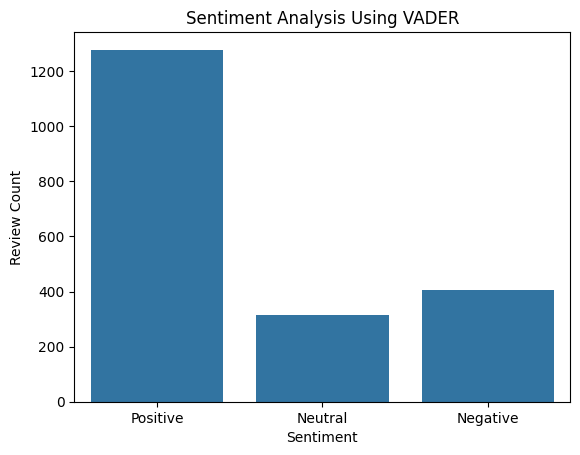

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=combined_reviews_df, x='sentiment_label', order=['Positive', 'Neutral', 'Negative'])
plt.title('Sentiment Analysis Using VADER')
plt.xlabel('Sentiment')
plt.ylabel('Review Count')
plt.show()


# Topic Modeling


In [22]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Preprocess function using spaCy for tokenization
def preprocess(text):
    doc = nlp(text.lower())
    # Tokenize
    return [token.text for token in doc if token.is_alpha and not token.is_stop]

In [23]:
texts = combined_reviews_df['content'].apply(preprocess)

# dictionary and corpus for LDA
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Applying LDA (Latent Dirichlet Allocation)
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

In [24]:
# View topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.020*"app" + 0.019*"whatsapp" + 0.015*"status" + 0.015*"like" + 0.013*"love"')
(1, '0.033*"app" + 0.027*"whatsapp" + 0.019*"number" + 0.016*"account" + 0.016*"phone"')
(2, '0.031*"app" + 0.021*"whatsapp" + 0.018*"group" + 0.014*"phone" + 0.010*"chat"')
(3, '0.042*"good" + 0.028*"whatsapp" + 0.014*"app" + 0.014*"ai" + 0.010*"like"')
(4, '0.040*"whatsapp" + 0.029*"app" + 0.011*"video" + 0.010*"use" + 0.008*"like"')


### Visualisation

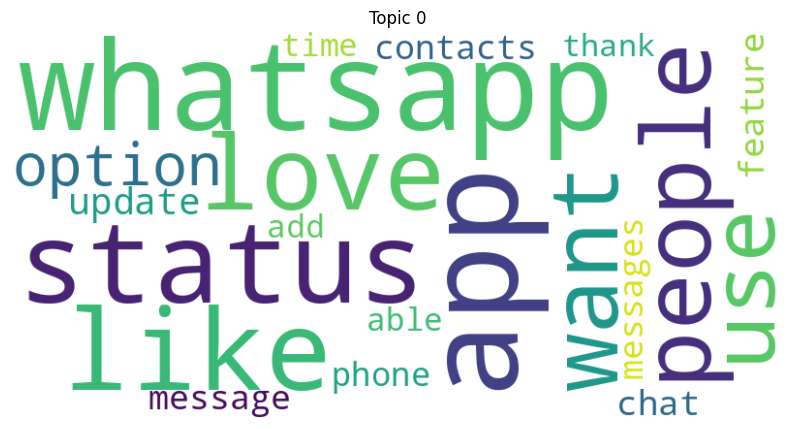

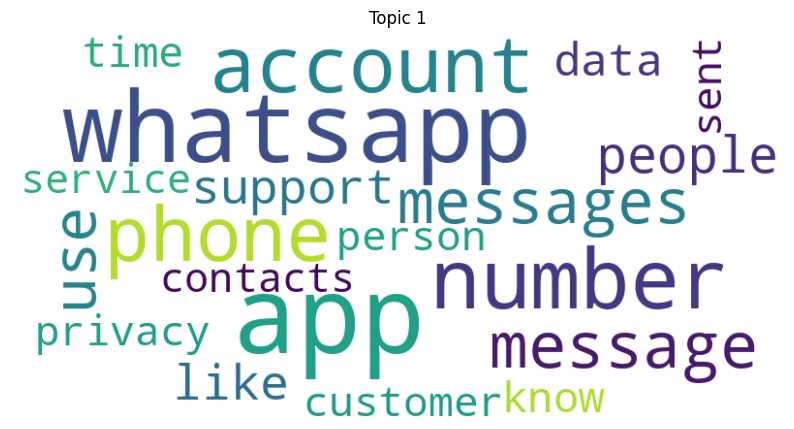

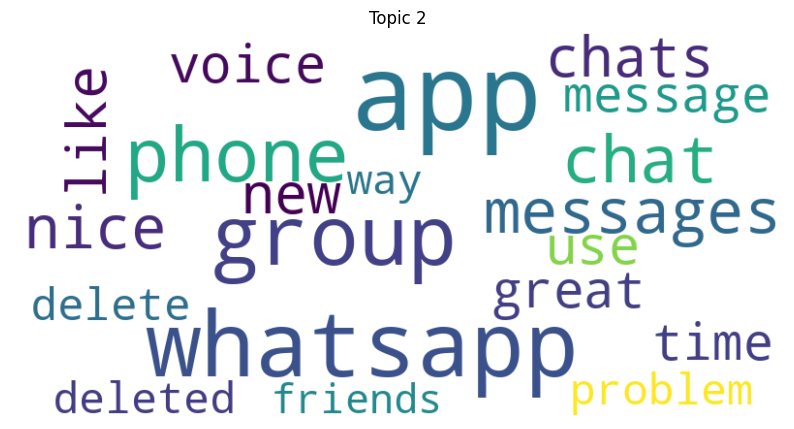

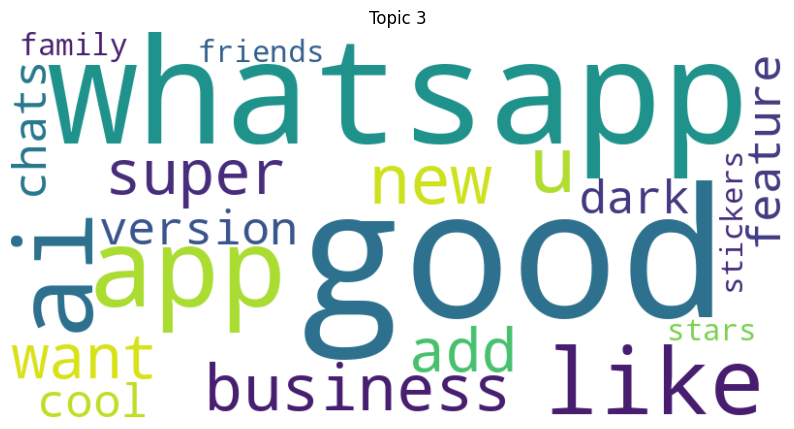

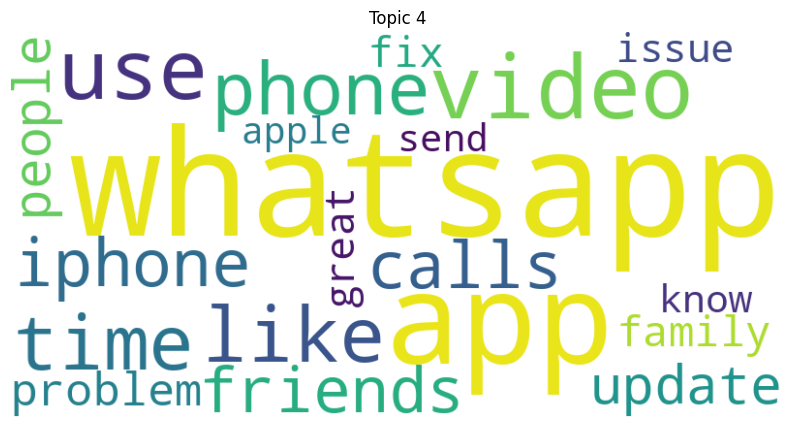

In [25]:
# Generate word clouds for each topic
for i in range(lda_model.num_topics):
    plt.figure(figsize=(10, 8))
    # Get the top 20 words for each topic
    words = lda_model.show_topic(i, topn=20)  # Use 'topn' instead of 'num_words'

    # Create the word cloud from the frequencies
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(words))

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Topic {i}')
    plt.axis('off')  # Hide axes
    plt.show()


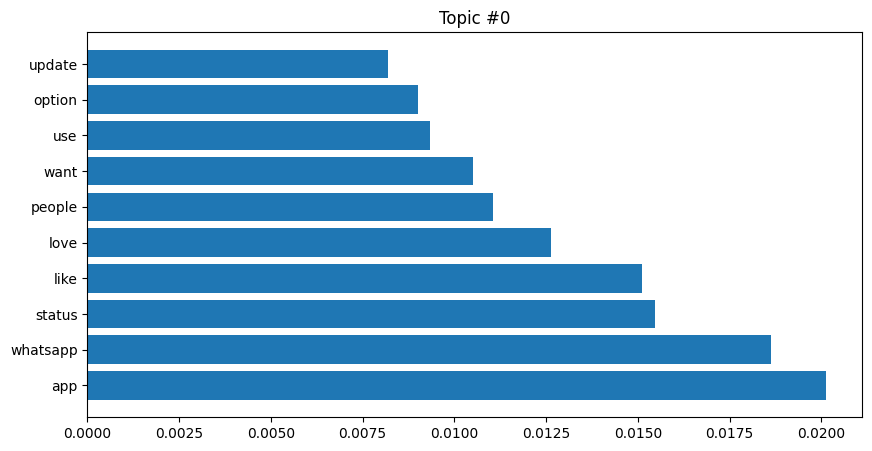

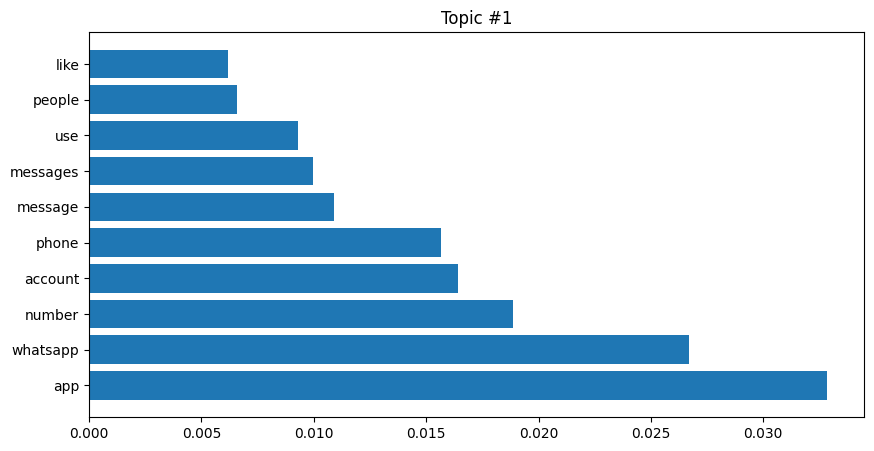

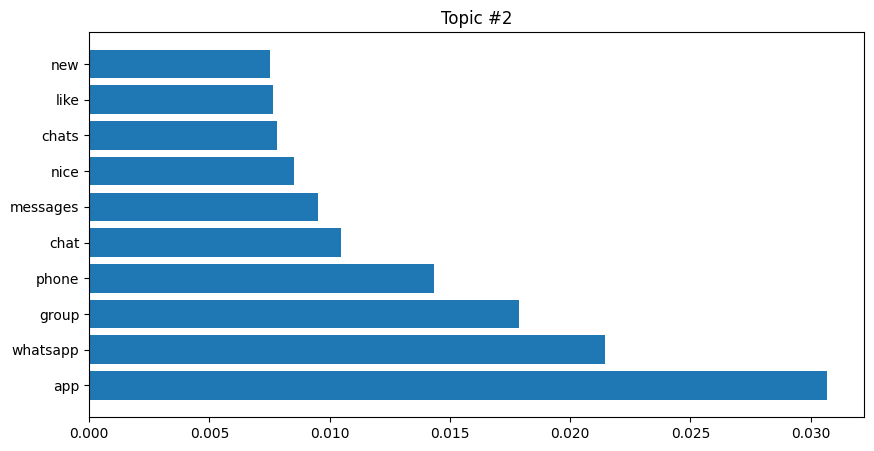

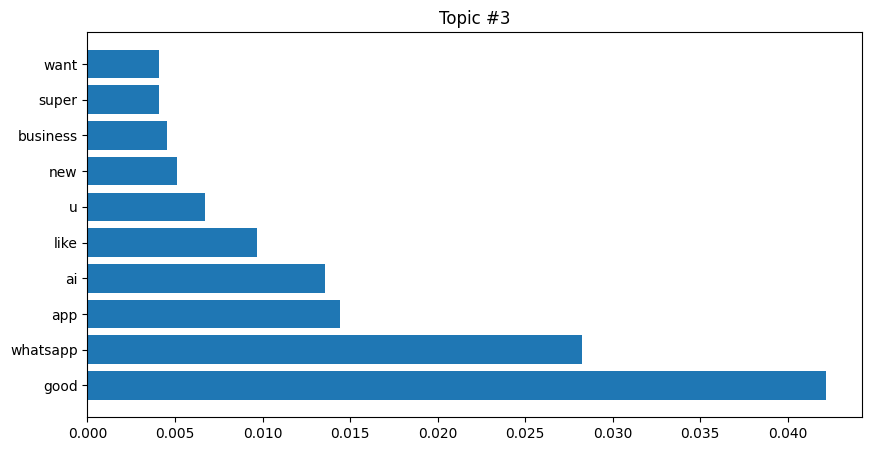

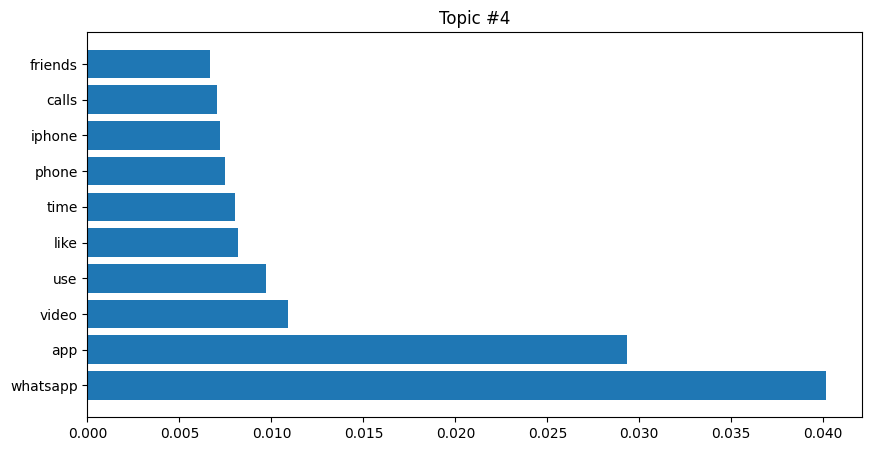

In [26]:
# Plot the top words for each topic
num_words = 10
for i in range(lda_model.num_topics):
    plt.figure(figsize=(10, 5))
    words = lda_model.show_topic(i, topn=num_words)
    words = [word[0] for word in words]
    plt.barh(range(num_words), [word[1] for word in lda_model.show_topic(i, topn=num_words)])
    plt.yticks(range(num_words), words)
    plt.title(f"Topic #{i}")
    plt.show()
